# Azure ML Studio Tutorial: Image Classification with CIFAR-10

This tutorial walks you through training a simple convolutional neural network (CNN) on the CIFAR-10 dataset using PyTorch in Azure ML Studio.

We will:
- Load and preprocess the CIFAR-10 dataset
- Define a basic CNN model
- Train the model on Azure ML
- Log metrics and register the model

This notebook is designed to be run inside an **Azure ML Compute Instance** or with a **Compute Cluster** using an Azure ML experiment.


In [1]:
!pip install --upgrade azure-ai-ml torchvision torch matplotlib numpy

import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from azureml.core import Workspace, Experiment, Run
from azureml.core.model import Model

print("Libraries imported.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.7 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 116.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 72.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## Load and Preprocess CIFAR-10 Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)


100%|██████████| 170M/170M [00:22<00:00, 7.52MB/s] 


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Define CNN Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


## Define Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the Model and Log with Azure ML

In [5]:
run = Run.get_context()
losses = [] # storing losses in a list
for epoch in range(5): # 5 epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    run.log("loss", avg_loss)

print('Finished Training')


Epoch 1, Loss: 1.4586
Attempted to log scalar metric loss:
1.4585714625275654
Epoch 2, Loss: 1.1323
Attempted to log scalar metric loss:
1.1322705451484836
Epoch 3, Loss: 0.9808
Attempted to log scalar metric loss:
0.9807716800123835
Epoch 4, Loss: 0.8756
Attempted to log scalar metric loss:
0.8755530091502782
Epoch 5, Loss: 0.7918
Attempted to log scalar metric loss:
0.791836891866401
Finished Training


## Save and Register the Model

In [6]:
os.makedirs("outputs", exist_ok=True)
torch.save(model.state_dict(), "outputs/cifar_model.pth")

run.upload_file("outputs/cifar_model.pth", "outputs/cifar_model.pth")
run.complete()


Attempted to track file outputs/cifar_model.pth at outputs/cifar_model.pth


*Check Predictions *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


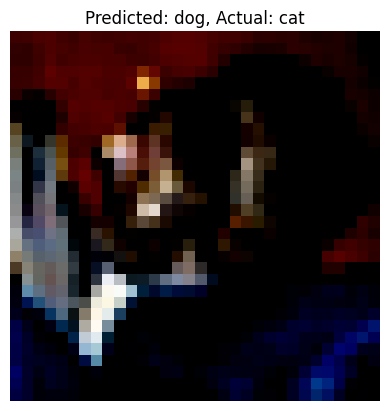

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


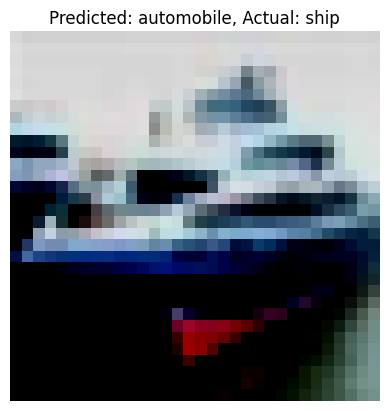

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


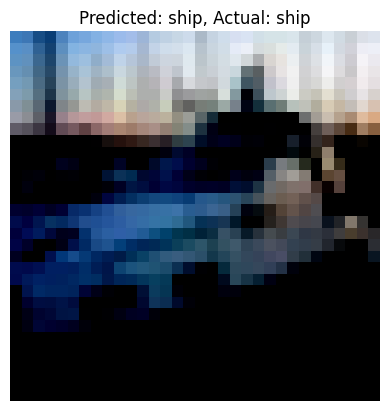

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


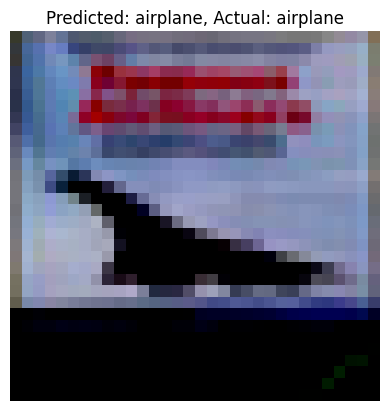

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


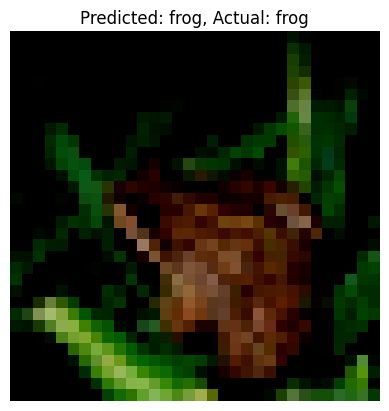

In [7]:

import matplotlib.pyplot as plt
import numpy as np

# Helper: plot a few test images with predictions
def show_predictions(model, testloader, classes, device, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
                plt.title(f"Predicted: {classes[preds[i]]}, Actual: {classes[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

# Call this function to visualize predictions
show_predictions(model, testloader, classes, device)


Plot Metrics

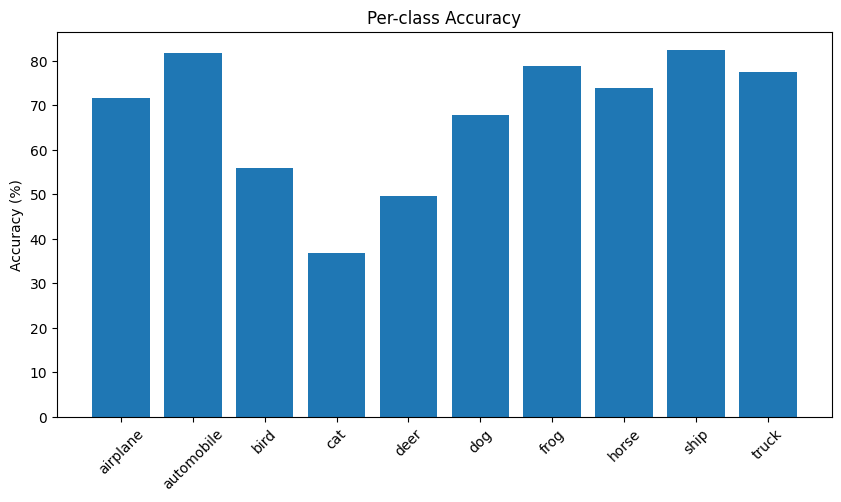

In [11]:

correct = [0] * len(classes)
total = [0] * len(classes)

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            total[label] += 1
            if label == prediction:
                correct[label] += 1

class_accuracy = [100 * c / t if t != 0 else 0 for c, t in zip(correct, total)]

plt.figure(figsize=(10,5))
plt.bar(classes, class_accuracy)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy')
plt.xticks(rotation=45)
plt.show()
